# User Interest Profiling & Topic Modeling from Synthetic Newsletter Data

**Objective:** This notebook demonstrates a methodology for extracting deeper insights such as user interests, trending topics, and (conceptually) purchasing behaviors. It leverages:
1.  Previously generated synthetic product data (`synthetic_newsletter_product_data.csv`).
2.  Simulation of user interactions with these synthetic products.
3.  The Google Generative AI SDK (Gemini API) to infer user profiles based on these simulated interactions.
4.  Topic modeling (BERTopic with SBERT embeddings) on product descriptions to identify overarching themes.
5.  Visualization of inferred user profiles and discovered topics.

**Steps:**
1.  **Setup & Configuration:** Import libraries, load API keys, configure SDKs, define paths, and set parameters.
2.  **Load Synthetic Product Data:** Load the CSV generated by `02_synthetic_product_data_generation.ipynb`.
3.  **Simulate User Interactions:** Create synthetic user "browsing histories" based on the product data.
4.  **LLM for User Profile Inference:** Define a function to use Gemini to analyze interaction histories and generate user profiles (interests, summary).
5.  **Topic Modeling:**
    a.  Generate SBERT embeddings for all product descriptions.
    b.  Apply BERTopic to discover topics.
6.  **Process and Analyze:**
    a.  Generate profiles for all synthetic users.
    b.  Showcase an example user: their interactions, inferred profile, and relation to discovered topics.
    c.  Visualize user profile summaries (e.g., word clouds).
    d.  Visualize discovered topics (e.g., top terms, word clouds).
7.  **Save Results:** Save generated user profiles and any relevant topic modeling outputs.
8.  **Discussion:** Briefly discuss how this framework could infer purchasing behaviors with real data.

**Prerequisites:**
- Ensure libraries are installed:
  `pip install google-generativeai pandas python-dotenv sentence-transformers scikit-learn matplotlib seaborn bertopic umap-learn hdbscan wordcloud`
  (Note: `umap-learn` and `hdbscan` are often dependencies for BERTopic for dimensionality reduction and clustering respectively).
- A `.env` file in the project root with `GEMINI_API_KEY`.
- `synthetic_newsletter_product_data.csv` present in `data/processed/`.
- A suitable font file (e.g., NotoSans-Regular.ttf or a Thai-specific font like NotoSansThai-Regular.ttf) downloaded and placed in your project, and its path updated in CELL 4.


In [45]:
import os
import json
import pandas as pd
import numpy as np # For random choices
from dotenv import load_dotenv
import asyncio
import time 
import random

# For running async code in Jupyter environments smoothly
import nest_asyncio
nest_asyncio.apply()

# Google Generative AI SDK
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from google.api_core import exceptions as google_api_exceptions

# Embeddings and Topic Modeling
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer # For BERTopic C-TF-IDF

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Informational check for environment
try:
    from js import fetch 
    IS_CANVAS_ENV = True
    print("Running in a Canvas-like (Pyodide/JavaScript) environment.")
except ImportError:
    IS_CANVAS_ENV = False
    print("Not running in a Canvas-like environment (standard Python execution).")

Not running in a Canvas-like environment (standard Python execution).


## 2. Configuration

Define essential variables for API keys, paths, generation parameters, and model names.

In [46]:
def load_api_key(project_r):
    env_path = os.path.join(project_r, '.env')
    if os.path.exists(env_path):
        load_dotenv(dotenv_path=env_path)
        print(f".env file loaded from: {env_path}")
    else:
        load_dotenv()
        if os.path.exists(".env"): print(f".env file loaded from current directory: {os.getcwd()}/.env")
        else: print(f"Warning: .env file not found at {env_path} or in current directory.")
    api_key_loaded = os.getenv("GEMINI_API_KEY")
    if not api_key_loaded: print("Warning: GEMINI_API_KEY not found.")
    else: print("GEMINI_API_KEY loaded.")
    return api_key_loaded

# --- Determine Project Root ---
current_working_dir = os.getcwd()
print(f"Current working directory (os.getcwd()): {current_working_dir}")
if os.path.basename(current_working_dir).lower() == "notebooks":
    PROJECT_ROOT = os.path.abspath(os.path.join(current_working_dir, ".."))
else:
    PROJECT_ROOT = current_working_dir 
print(f"PROJECT_ROOT set to: {PROJECT_ROOT}")

API_KEY = load_api_key(PROJECT_ROOT)

# --- Configure Google Generative AI SDK ---
SDK_CONFIGURED_SUCCESSFULLY = False
if API_KEY: 
    try:
        genai.configure(api_key=API_KEY)
        SDK_CONFIGURED_SUCCESSFULLY = True
        print("Google Generative AI SDK configured successfully.")
    except Exception as e: print(f"Error configuring Google Generative AI SDK: {e}")
else: print("Google Generative AI SDK not configured due to missing API key.")

# --- Directory and File Paths ---
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
FONTS_DIR = os.path.join(PROJECT_ROOT, "fonts") # Optional: For storing fonts
DATA_PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
RESULTS_FIGURES_DIR = os.path.join(RESULTS_DIR, "figures") # For saving plots

INPUT_SYNTHETIC_DATA_CSV = os.path.join(DATA_PROCESSED_DIR, "synthetic_newsletter_product_data.csv")
OUTPUT_USER_PROFILES_CSV = os.path.join(DATA_PROCESSED_DIR, "synthetic_user_profiles.csv")
OUTPUT_TOPIC_VIS_PATH = os.path.join(RESULTS_FIGURES_DIR, "bertopic_visualization.html")
OUTPUT_USER_PROFILE_WORDCLOUD_PATH_TEMPLATE = os.path.join(RESULTS_FIGURES_DIR, "user_profile_wordcloud_user_{user_id}.png")
OUTPUT_TOPIC_WORDCLOUD_PATH_TEMPLATE = os.path.join(RESULTS_FIGURES_DIR, "topic_wordcloud_topic_{topic_id}.png")

# --- Font Path for WordCloud (IMPORTANT: User needs to set this) ---
# Download a font like NotoSans-Regular.ttf (covers many scripts) or a specific one like NotoSansThai-Regular.ttf
# and place it in your project (e.g., in a 'fonts' directory or project root).
# Update the path below accordingly.
# If FONT_PATH is None, WordCloud will use its default font, which may not support all characters.
DEFAULT_FONT_PATH = os.path.join(FONTS_DIR, "NotoSans-Regular.ttf") # Example path
# Check if the default font exists, otherwise set to None
if os.path.exists(DEFAULT_FONT_PATH):
    FONT_PATH = DEFAULT_FONT_PATH
    print(f"Using font for WordCloud: {FONT_PATH}")
else:
    FONT_PATH = None # WordCloud will use its default
    print(f"Warning: Font for WordCloud not found at {DEFAULT_FONT_PATH}. WordCloud will use its default font.")
    print("For multilingual word clouds (especially Thai/Indonesian), please download a suitable font (e.g., Noto Sans from Google Fonts),")
    print(f"place it in a known location (e.g., '{FONTS_DIR}'), and update FONT_PATH in this cell.")


# --- Simulation Parameters ---
NUM_SYNTHETIC_USERS = 20  # Number of synthetic users to create
MIN_ITEMS_PER_USER = 3    # Min items in a user's interaction history
MAX_ITEMS_PER_USER = 8    # Max items in a user's interaction history

# --- API Interaction Parameters ---
API_CALL_DELAY_SECONDS = 7 
API_MAX_RETRIES = 2        
API_RETRY_DELAY_SECONDS = 10

# --- Embedding & Topic Modeling Parameters ---
SBERT_MODEL_NAME = 'paraphrase-multilingual-MiniLM-L12-v2' 
TOP_N_TOPICS_TO_VISUALIZE = 5 # For word clouds

# --- Ensure directories exist ---
for dir_path in [DATA_PROCESSED_DIR, RESULTS_FIGURES_DIR, FONTS_DIR]: # Added FONTS_DIR
    if not os.path.exists(dir_path): 
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")

print(f"Input synthetic data CSV: {INPUT_SYNTHETIC_DATA_CSV}")
print(f"Output user profiles CSV: {OUTPUT_USER_PROFILES_CSV}")
print(f"Output figures directory: {RESULTS_FIGURES_DIR}")

Current working directory (os.getcwd()): /mnt/c/Users/tduricic/Development/workspace/conversational-reco/notebooks
PROJECT_ROOT set to: /mnt/c/Users/tduricic/Development/workspace/conversational-reco
.env file loaded from: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/.env
GEMINI_API_KEY loaded.
Google Generative AI SDK configured successfully.
Using font for WordCloud: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/fonts/NotoSans-Regular.ttf
Input synthetic data CSV: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/data/processed/synthetic_newsletter_product_data.csv
Output user profiles CSV: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/data/processed/synthetic_user_profiles.csv
Output figures directory: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/results/figures


## 3. Load Synthetic Product Data

Load the `synthetic_newsletter_product_data.csv` file generated in the previous notebook (`02_...`). This dataset contains product details including names, categories, descriptions, and store source.

In [47]:
def load_synthetic_product_data(file_path):
    if not os.path.exists(file_path):
        print(f"Error: Synthetic product data file not found at {file_path}.")
        print("Please ensure '02_synthetic_product_data_generation.ipynb' has been run successfully.")
        return pd.DataFrame()
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {len(df)} products from {file_path}.")
        # Basic cleaning: ensure product_description is string and fill NaNs
        df['product_description'] = df['product_description'].astype(str).fillna('')
        df['product_name'] = df['product_name'].astype(str).fillna('')
        df['category'] = df['category'].astype(str).fillna('')
        return df
    except Exception as e:
        print(f"Error loading or processing CSV from {file_path}: {e}")
        return pd.DataFrame()

synthetic_products_df = load_synthetic_product_data(INPUT_SYNTHETIC_DATA_CSV)
if not synthetic_products_df.empty:
    print("\nSample of loaded synthetic product data:")
    print(synthetic_products_df.head())
else:
    print("\nStopping execution as synthetic product data could not be loaded.")
    # Depending on the environment, you might want to raise an error or exit.
    # For a notebook, we'll just print and subsequent cells might fail.

Successfully loaded 153 products from /mnt/c/Users/tduricic/Development/workspace/conversational-reco/data/processed/synthetic_newsletter_product_data.csv.

Sample of loaded synthetic product data:
  newsletter_source                                 product_name   category  \
0             Konvy           เซรั่มวิตามินซีเข้มข้น Dermabright   Skincare   
1             Konvy  ลิปสติกเนื้อแมท Lancome Matte Lipstick #201     Makeup   
2             Konvy                 แชมพูบำรุงผม Sunsilk Keratin   Haircare   
3             Konvy                    น้ำหอมผู้หญิง Chanel No.5  Fragrance   
4             Konvy        โลชั่นบำรุงผิว Vaseline Healthy White  Body Care   

   price   availability                                        product_url  \
0   ฿399       In Stock  https://www.konvy.com/Dermabright/serum-vitami...   
1   ฿450  Limited Stock  https://www.konvy.com/Lancome/lipstick-matte-2...   
2   ฿299       In Stock  https://www.konvy.com/Sunsilk/shampoo-keratin-...   
3  ฿1200       

## 4. Simulate User Interactions

To infer user profiles, we first need to simulate user activity. This function will create a set of synthetic users and, for each user, generate a "browsing history" consisting of a random selection of products from our synthetic catalog.

We can introduce simple personas to make interactions more diverse:
- **Persona 1: Store-Specific Shopper:** Interacts primarily with products from one specific store.
- **Persona 2: Category Explorer:** Interacts with products from a specific category across different stores.
- **Persona 3: Random Browser:** Interacts with products more randomly.

In [48]:
def simulate_user_interactions(product_df, num_users, min_items, max_items):
    if product_df.empty:
        print("Product DataFrame is empty. Cannot simulate interactions.")
        return []

    user_interactions = []
    stores = product_df['newsletter_source'].unique()
    all_categories = product_df['category'].unique()

    for user_id in range(1, num_users + 1):
        num_items_for_user = random.randint(min_items, max_items)
        user_history = []
        
        # Assign a persona type randomly
        persona_type = random.choice(["store_specific", "category_explorer", "random_browser"])
        
        temp_df = product_df.copy()

        if persona_type == "store_specific" and len(stores) > 0:
            chosen_store = random.choice(stores)
            temp_df = product_df[product_df['newsletter_source'] == chosen_store]
            # print(f"User {user_id} (Store Specific: {chosen_store}), items: {num_items_for_user}")
            if temp_df.empty: # Fallback if store has no items (should not happen with good data)
                temp_df = product_df.copy()


        elif persona_type == "category_explorer" and len(all_categories) > 0:
            chosen_category = random.choice(all_categories)
            temp_df = product_df[product_df['category'] == chosen_category]
            # print(f"User {user_id} (Category Explorer: {chosen_category}), items: {num_items_for_user}")
            if temp_df.empty: # Fallback
                 temp_df = product_df.copy()
        # else:
            # print(f"User {user_id} (Random Browser), items: {num_items_for_user}")

        if len(temp_df) < num_items_for_user : # if filtered df has less items than needed
            # print(f"Warning: Not enough items for User {user_id} with persona '{persona_type}'. Sampling from all products.")
            sampled_items = product_df.sample(n=min(num_items_for_user, len(product_df)), replace=False)
        elif len(temp_df) == 0: # Should not happen if product_df is not empty
             print(f"Warning: temp_df is empty for User {user_id}. Skipping this user.")
             continue
        else:
            sampled_items = temp_df.sample(n=num_items_for_user, replace=False)

        for _, row in sampled_items.iterrows():
            user_history.append({
                "product_name": row["product_name"],
                "category": row["category"],
                "product_description": row["product_description"],
                "newsletter_source": row["newsletter_source"] # Keep store info for context
            })
        
        user_interactions.append({
            "user_id": f"user_{user_id}",
            "interactions": user_history,
            "persona_type_for_generation": persona_type # For our reference
        })
        
    print(f"\nGenerated {len(user_interactions)} synthetic user interaction logs.")
    return user_interactions

if not synthetic_products_df.empty:
    synthetic_user_interactions = simulate_user_interactions(
        synthetic_products_df, 
        NUM_SYNTHETIC_USERS, 
        MIN_ITEMS_PER_USER, 
        MAX_ITEMS_PER_USER
    )
    if synthetic_user_interactions:
        print("\nSample of a synthetic user interaction log:")
        print(json.dumps(synthetic_user_interactions[0], indent=2, ensure_ascii=False))
else:
    synthetic_user_interactions = []
    print("Skipping user interaction simulation as product data is not available.")


Generated 20 synthetic user interaction logs.

Sample of a synthetic user interaction log:
{
  "user_id": "user_1",
  "interactions": [
    {
      "product_name": "Tempat Pensil Plastik Transparan",
      "category": "Tempat Pensil",
      "product_description": "Tempat pensil transparan dari plastik, mudah melihat isi di dalamnya.",
      "newsletter_source": "Gramedia"
    },
    {
      "product_name": "Pulpen Stabilo Biru",
      "category": "Pulpen",
      "product_description": "Pulpen Stabilo dengan tinta biru yang lancar dan nyaman digunakan.",
      "newsletter_source": "Gramedia"
    },
    {
      "product_name": "Kertas Printer A4 70gsm",
      "category": "Kertas Printer",
      "product_description": "Kertas printer A4 70gsm berkualitas, cocok untuk mencetak dokumen dan foto.",
      "newsletter_source": "Gramedia"
    },
    {
      "product_name": "Organizer Meja Plastik",
      "category": "Organizer Meja",
      "product_description": "Organizer meja praktis untuk m

## 5. LLM for User Profile Inference

This function uses the Gemini API to analyze a synthetic user's interaction history (list of "viewed" products) and infer their interests, preferred categories, and a profile summary.

In [49]:
USER_PROFILE_SCHEMA = {
    "type": "OBJECT",
    "properties": {
        "inferred_interests": {
            "type": "ARRAY",
            "items": {"type": "STRING"},
            "description": "List of specific user interests inferred from the products (e.g., 'anti-aging skincare', 'Japanese manga', 'sustainable fashion', 'historical fiction'). Be specific and diverse."
        },
        "preferred_categories": {
            "type": "ARRAY",
            "items": {"type": "STRING"},
            "description": "List of product categories the user seems to favor, based on the interacted items."
        },
        "profile_summary": {
            "type": "STRING",
            "description": "A concise (1-2 sentences) textual summary describing the key preferences and likely shopping focus. Example: 'Focuses on skincare products, particularly anti-aging serums.' If product descriptions are in a specific language (e.g., Thai, Indonesian), attempt the summary in that language, otherwise use English."
        },
        "potential_next_product_types": {
            "type": "ARRAY",
            "items": {"type": "STRING"},
            "description": "Suggest 2-3 types of products or specific product themes this user might be interested in next, based on their interactions."
        }
    },
    "required": ["inferred_interests", "preferred_categories", "profile_summary", "potential_next_product_types"]
}

async def infer_user_profile_with_gemini(user_id, interaction_history):
    if not SDK_CONFIGURED_SUCCESSFULLY:
        print(f"SDK not configured. Cannot infer profile for {user_id}.")
        return None
    if not interaction_history:
        print(f"No interaction history for {user_id}. Cannot infer profile.")
        return None

    print(f"Inferring profile for {user_id}...")

    # Prepare a summary of interactions for the prompt
    interaction_summary_parts = []
    for item in interaction_history:
        interaction_summary_parts.append(
            f"- Product: '{item.get('product_name', 'N/A')}' (Category: {item.get('category', 'N/A')}, Store: {item.get('newsletter_source', 'N/A')}). Description snippet: \"{item.get('product_description', '')[:100]}...\""
        )
    interaction_text = "\n".join(interaction_summary_parts)

    prompt = f"""
    You are an expert user profiler for e-commerce. Based on the following list of products a user has interacted with, please infer their profile.

    User Interaction History:
    {interaction_text}

    Based *only* on these interactions, provide the following in JSON format according to the schema:
    - inferred_interests: Specific interests.
    - preferred_categories: Categories they seem to like.
    - profile_summary: Generate a 1-2 sentence summary describing the key preferences and likely shopping focus. For example, instead of 'This user likes skincare', try 'Focuses on skincare products, particularly anti-aging serums.' If product descriptions are in a specific language (e.g., Thai, Indonesian), attempt the summary in that language, otherwise use English.
    - potential_next_product_types: 2-3 suggestions for what they might like next.

    Be insightful and base your inferences strictly on the provided interaction data. Avoid generic phrases like 'The user is interested in...' in the profile_summary. Focus on the preferences themselves.
    """

    safety_settings = {
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    }
    model = genai.GenerativeModel(model_name='gemini-1.5-flash-latest', safety_settings=safety_settings)
    generation_config = genai.types.GenerationConfig(
        response_mime_type="application/json",
        response_schema=USER_PROFILE_SCHEMA
    )

    for attempt in range(API_MAX_RETRIES):
        try:
            # print(f"Attempt {attempt + 1} for user {user_id} profile inference...")
            response = await model.generate_content_async(
                contents=[prompt],
                generation_config=generation_config
            )
            profile_data = json.loads(response.text)
            profile_data['user_id'] = user_id # Add user_id back for tracking
            # print(f"Profile inferred for {user_id}.")
            return profile_data
        except Exception as e:
            print(f"Error inferring profile for {user_id} (Attempt {attempt+1}): {type(e).__name__} - {e}")
            if attempt < API_MAX_RETRIES - 1:
                await asyncio.sleep(API_RETRY_DELAY_SECONDS)
            else:
                print(f"Max retries reached for user {user_id}. Failed to infer profile.")
                return None
    return None

## 6. Topic Modeling with BERTopic

We will use BERTopic to identify underlying topics from the `product_description` field of our synthetic product data. BERTopic leverages SBERT embeddings and HDBSCAN clustering to find coherent topics.

In [50]:
def perform_topic_modeling(product_df, sbert_model_name):
    if product_df.empty or 'product_description' not in product_df.columns:
        print("Product data is empty or 'product_description' column is missing. Skipping topic modeling.")
        return None, pd.DataFrame()

    descriptions = product_df['product_description'].tolist()
    if not any(desc.strip() for desc in descriptions): # Check if all descriptions are empty
        print("All product descriptions are empty. Skipping topic modeling.")
        return None, product_df


    print(f"\nLoading SBERT model for topic modeling: {sbert_model_name}...")
    try:
        embedding_model = SentenceTransformer(sbert_model_name)
        print("SBERT model loaded.")
    except Exception as e:
        print(f"Error loading SBERT model '{sbert_model_name}': {e}. Skipping topic modeling.")
        return None, product_df
        
    print("Generating embeddings for all product descriptions (for BERTopic)...")
    doc_embeddings = embedding_model.encode(descriptions, show_progress_bar=True)

    # To prevent issues with too few samples for UMAP/HDBSCAN defaults
    nr_topics = 'auto'
    min_topic_size = max(2, len(descriptions) // 50) # Adjust min_topic_size based on dataset size

    # Using CountVectorizer with a simple stop word list for English, as BERTopic does C-TF-IDF
    # For multilingual, a more sophisticated approach or no stop words might be better.
    # For simplicity, we'll use a basic English list.
    vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1,2))


    print(f"Running BERTopic (min_topic_size={min_topic_size})...")
    try:
        topic_model = BERTopic(
            embedding_model=embedding_model, # We can pass the SBERT model directly or pre-computed embeddings
            vectorizer_model=vectorizer_model,
            language="multilingual", # Important for BERTopic
            nr_topics=nr_topics, 
            min_topic_size=min_topic_size,
            calculate_probabilities=False # Can set to True if needed, but adds computation
        )
        topics, _ = topic_model.fit_transform(documents=descriptions, embeddings=doc_embeddings) # Pass embeddings
        
        product_df_with_topics = product_df.copy()
        product_df_with_topics['topic_id'] = topics
        
        print("\nBERTopic modeling complete.")
        print(topic_model.get_topic_info())
        return topic_model, product_df_with_topics
    except Exception as e:
        print(f"Error during BERTopic processing: {e}")
        return None, product_df # Return original df without topics

if not synthetic_products_df.empty:
    topic_model_instance, products_with_topics_df = perform_topic_modeling(synthetic_products_df, SBERT_MODEL_NAME)
else:
    topic_model_instance, products_with_topics_df = None, pd.DataFrame()


Loading SBERT model for topic modeling: paraphrase-multilingual-MiniLM-L12-v2...
SBERT model loaded.
Generating embeddings for all product descriptions (for BERTopic)...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Running BERTopic (min_topic_size=3)...

BERTopic modeling complete.
   Topic  Count                                               Name  \
0     -1      5  -1_breathable_moisture_moisture wicking_wickin...   
1      0     52                             0_dan_yang_untuk_edisi   
2      1     43  1_petualangan_stylish practical_menarik_ดทนนาน...   
3      2     13                     2_warm_perfect_weather_stylish   
4      3     12  3_cotton_soft_comfortable cotton_soft comfortable   
5      4     10  4_comfortable_style_comfortable versatile_vers...   
6      5     10            5_shirt_cotton_breathable_shirt perfect   
7      6      8                            6_นหอมสดช_ดทนนานตลอดว__   

                                      Representation  \
0  [breathable, moisture, moisture wicking, wicki...   
1  [dan, yang, untuk, edisi, seru, dari, stylish ...   
2  [petualangan, stylish practical, menarik, ดทนน...   
3  [warm, perfect, weather, stylish, soft, design...   
4  [cotton, soft, com

## 7. Process User Profiles, Analyze, and Visualize

This section orchestrates the following:
- Generates profiles for all synthetic users using the LLM.
- **Showcases an example:** Prints interactions and the inferred profile for one user, and discusses potential links to topics.
- **Visualizes:** Creates word clouds for sample user profile summaries and for the top discovered topics.
- Saves the generated user profiles to a CSV.

In [51]:
async def run_analysis_and_visualization(users_interactions, product_df_with_topics, topic_model):
    if not SDK_CONFIGURED_SUCCESSFULLY:
        print("SDK not configured. Skipping user profile generation and analysis.")
        return

    all_user_profiles_data = []
    if users_interactions:
        for user_data in users_interactions:
            profile = await infer_user_profile_with_gemini(user_data['user_id'], user_data['interactions'])
            if profile:
                # Add persona type for reference, if available
                profile['persona_type_for_generation'] = user_data.get('persona_type_for_generation', 'N/A')
                all_user_profiles_data.append(profile)
            if len(users_interactions) > 1 and user_data != users_interactions[-1]: # Avoid delay after last user
                 await asyncio.sleep(API_CALL_DELAY_SECONDS / 2) # Shorter delay between individual profile generations
    
    if not all_user_profiles_data:
        print("No user profiles were generated. Skipping further analysis.")
        return

    user_profiles_df = pd.DataFrame(all_user_profiles_data)
    print("\n--- Generated User Profiles (Sample) ---")
    print(user_profiles_df.head().to_string())
    try:
        user_profiles_df.to_csv(OUTPUT_USER_PROFILES_CSV, index=False, encoding='utf-8')
        print(f"\nUser profiles saved to: {OUTPUT_USER_PROFILES_CSV}")
    except Exception as e:
        print(f"Error saving user profiles CSV: {e}")

    # --- Showcase an example user ---
    if not user_profiles_df.empty and users_interactions:
        example_user_id = user_profiles_df.iloc[0]['user_id']
        example_user_profile = user_profiles_df.iloc[0]
        example_user_interaction_log = next((item for item in users_interactions if item["user_id"] == example_user_id), None)

        print(f"\n--- Showcase: User {example_user_id} ---")
        if example_user_interaction_log:
            print("\nInteracted Products:")
            for item in example_user_interaction_log['interactions']:
                print(f"  - {item['product_name']} (Store: {item['newsletter_source']}, Category: {item['category']})")
        
        print("\nLLM-Inferred Profile:")
        print(f"  Interests: {example_user_profile.get('inferred_interests')}")
        print(f"  Preferred Categories: {example_user_profile.get('preferred_categories')}")
        print(f"  Profile Summary: {example_user_profile.get('profile_summary')}")
        print(f"  Potential Next Products: {example_user_profile.get('potential_next_product_types')}")

        # Generate and save word cloud for this user's profile summary
        if example_user_profile.get('profile_summary'):
            try:
                wordcloud_path = OUTPUT_USER_PROFILE_WORDCLOUD_PATH_TEMPLATE.format(user_id=example_user_id)
                custom_stopwords = WordCloud().stopwords.copy() 
                custom_stopwords.add("user")
                custom_stopwords.add("User")

                wordcloud = WordCloud(
                    width=800, height=400, 
                    background_color='white',
                    stopwords=custom_stopwords,
                    font_path=FONT_PATH  # Use the configured font path
                ).generate(example_user_profile['profile_summary'])
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title(f"Word Cloud for User {example_user_id} Profile Summary")
                plt.savefig(wordcloud_path)
                print(f"Word cloud for user {example_user_id} saved to {wordcloud_path}")
                plt.show()
            except Exception as e:
                print(f"Could not generate word cloud for user {example_user_id}: {e}")


    # --- Visualize Topics (if topic modeling was successful) ---
    if topic_model and not products_with_topics_df.empty:
        print("\n--- Topic Modeling Visualization ---")
        try:
            fig_dir = os.path.dirname(OUTPUT_TOPIC_VIS_PATH) 
            if not os.path.exists(fig_dir):
                os.makedirs(fig_dir)
            
            topic_info_df = topic_model.get_topic_info()
            if len(topic_info_df[topic_info_df.Topic != -1]) > 0 : 
                fig = topic_model.visualize_topics()
                fig.write_html(OUTPUT_TOPIC_VIS_PATH)
                print(f"BERTopic interactive visualization saved to: {OUTPUT_TOPIC_VIS_PATH}")
            else:
                print("No significant topics found by BERTopic to visualize with visualize_topics().")

            print(f"\nGenerating word clouds for top {TOP_N_TOPICS_TO_VISUALIZE} topics...")
            for topic_id in topic_info_df[topic_info_df.Topic != -1].head(TOP_N_TOPICS_TO_VISUALIZE)['Topic']:
                topic_words = topic_model.get_topic(topic_id)
                if topic_words:
                    wordcloud_text = " ".join([word for word, _ in topic_words])
                    topic_name_for_title = f"Topic {topic_id}: " + ", ".join([word for word, _ in topic_words[:3]]) + "..."
                    try:
                        wc_path = OUTPUT_TOPIC_WORDCLOUD_PATH_TEMPLATE.format(topic_id=topic_id)
                        wordcloud = WordCloud(
                            width=800, height=400, 
                            background_color='white',
                            font_path=FONT_PATH # Use the configured font path
                        ).generate(wordcloud_text)
                        plt.figure(figsize=(10, 5))
                        plt.imshow(wordcloud, interpolation='bilinear')
                        plt.axis("off")
                        plt.title(topic_name_for_title)
                        plt.savefig(wc_path)
                        print(f"Word cloud for topic {topic_id} saved to {wc_path}")
                        plt.show()
                    except Exception as e:
                         print(f"Could not generate word cloud for topic {topic_id}: {e}")
                else:
                    print(f"No words found for topic {topic_id} to generate word cloud.")

        except Exception as e:
            print(f"Error during topic visualization: {e}")

## 8. Discussion: Inferring Purchasing Behaviors

While this notebook focuses on generating synthetic data and inferring user interests/profiles from *simulated* interactions, this framework lays the groundwork for understanding potential purchasing behaviors if real interaction data were available:

-   **Correlation of Profiles with Purchases:** If we had actual purchase data linked to users, the LLM-generated profiles (inferred interests, needs) could be correlated with what users actually buy. This could reveal patterns like "users interested in 'sustainable fashion' and 'minimalist design' are more likely to purchase linen shirts or organic cotton basics."
-   **Topic-Based Purchase Propensity:** The topics discovered from product descriptions can be analyzed against purchase data. For example, we could find that products belonging to "Topic X: DIY Craft Kits" have a higher conversion rate among users whose profiles indicate an interest in "hobbies" or "creative activities."
-   **Predictive Modeling:** User profiles and topic information could become features in a machine learning model designed to predict:
    -   Likelihood of a user purchasing a specific product.
    -   Next product a user might buy (extending the `potential_next_product_types` from the LLM).
    -   Customer lifetime value based on interest profiles.
-   **Sequence Analysis:** With real clickstream data leading to a purchase, we could analyze sequences of product views or topic interactions that frequently precede a purchase, indicating a "customer journey" or "purchasing funnel" related to certain interests or topics.
-   **Personalized Recommendations:** The inferred interests and preferred categories directly feed into personalizing product recommendations within the conversational agent. The "potential next product types" from the LLM can also guide proactive suggestions.

By combining rich, LLM-derived user understanding with broader content themes (topics), we can build a more nuanced and effective system for driving engagement and, ultimately, revenue. The synthetic data approach allows us to prototype and demonstrate these capabilities.

In [52]:
async def full_pipeline():
    # --- 1. Generate Synthetic Product Data (or ensure it's loaded) ---
    # This part assumes synthetic_products_df is loaded or generated by a previous notebook.
    # For this notebook, we primarily load it.
    global synthetic_products_df # Allow modification if it's empty
    if synthetic_products_df.empty:
        print("Synthetic product data is empty. Attempting to re-load or re-run previous notebook's generation.")
        # Optionally, you could call the generation function from notebook 02 here if needed.
        # For now, we rely on it being pre-existing.
        synthetic_products_df = load_synthetic_product_data(INPUT_SYNTHETIC_DATA_CSV)
        if synthetic_products_df.empty:
            print("CRITICAL: Synthetic product data could not be loaded. Cannot proceed.")
            return

    # --- 2. Simulate User Interactions ---
    global synthetic_user_interactions # Allow modification
    if not synthetic_products_df.empty:
        synthetic_user_interactions = simulate_user_interactions(
            synthetic_products_df, 
            NUM_SYNTHETIC_USERS, 
            MIN_ITEMS_PER_USER, 
            MAX_ITEMS_PER_USER
        )
    else:
        synthetic_user_interactions = []
        print("Skipping user interaction simulation as product data is not available.")


    # --- 3. Perform Topic Modeling ---
    global topic_model_instance, products_with_topics_df # Allow modification
    if not synthetic_products_df.empty:
        topic_model_instance, products_with_topics_df = perform_topic_modeling(synthetic_products_df, SBERT_MODEL_NAME)
    else:
        topic_model_instance, products_with_topics_df = None, pd.DataFrame()
        print("Skipping topic modeling as product data is not available.")

    # --- 4. Run Analysis (Profile Generation) and Visualization ---
    if synthetic_user_interactions and (topic_model_instance is not None): # Check topic_model_instance directly
        await run_analysis_and_visualization(synthetic_user_interactions, products_with_topics_df, topic_model_instance)
    else:
        print("\nSkipping main analysis and visualization due to missing prerequisite data (user interactions or topic model).")


Generated 20 synthetic user interaction logs.

Loading SBERT model for topic modeling: paraphrase-multilingual-MiniLM-L12-v2...
SBERT model loaded.
Generating embeddings for all product descriptions (for BERTopic)...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Running BERTopic (min_topic_size=3)...

BERTopic modeling complete.
   Topic  Count                                               Name  \
0      0     52                             0_dan_yang_untuk_edisi   
1      1     50        1_perfect_everyday_perfect everyday_stylish   
2      2     43  2_petualangan_stylish practical_menarik_ดทนนาน...   
3      3      8                            3_นหอมสดช_ดทนนานตลอดว__   

                                      Representation  \
0  [dan, yang, untuk, edisi, seru, dari, stylish ...   
1  [perfect, everyday, perfect everyday, stylish,...   
2  [petualangan, stylish practical, menarik, ดทนน...   
3             [นหอมสดช, ดทนนานตลอดว, , , , , , , , ]   

                                 Representative_Docs  
0  [Buku inspiratif yang mengajarkan 7 kebiasaan ...  
1  [Comfortable and versatile leggings.  Perfect ...  
2  [Stylish and practical baseball cap.  Protects...  
3  [น้ำหอมกลิ่นหอมสดชื่น, น้ำหอมกลิ่นหอมสดชื่น  ต...  
Inferring profile for use

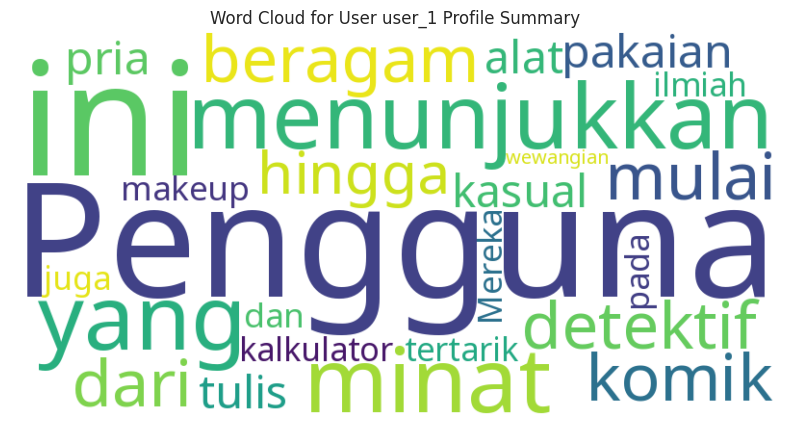


--- Topic Modeling Visualization ---
BERTopic interactive visualization saved to: /mnt/c/Users/tduricic/Development/workspace/conversational-reco/results/figures/bertopic_visualization.html

Generating word clouds for top 5 topics...
Word cloud for topic 0 saved to /mnt/c/Users/tduricic/Development/workspace/conversational-reco/results/figures/topic_wordcloud_topic_0.png


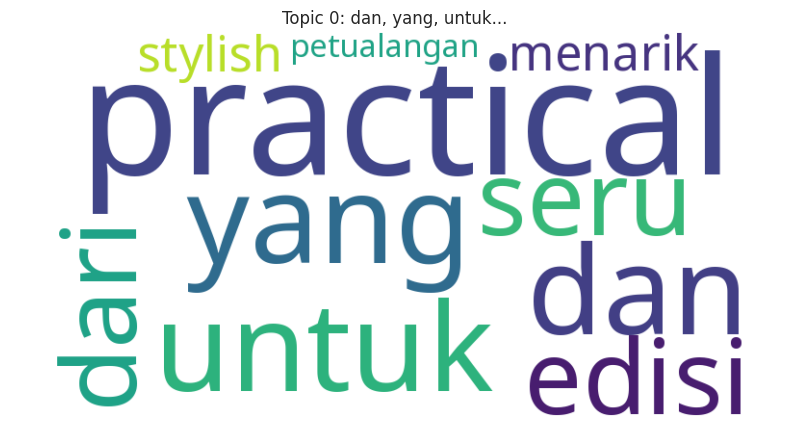

Word cloud for topic 1 saved to /mnt/c/Users/tduricic/Development/workspace/conversational-reco/results/figures/topic_wordcloud_topic_1.png


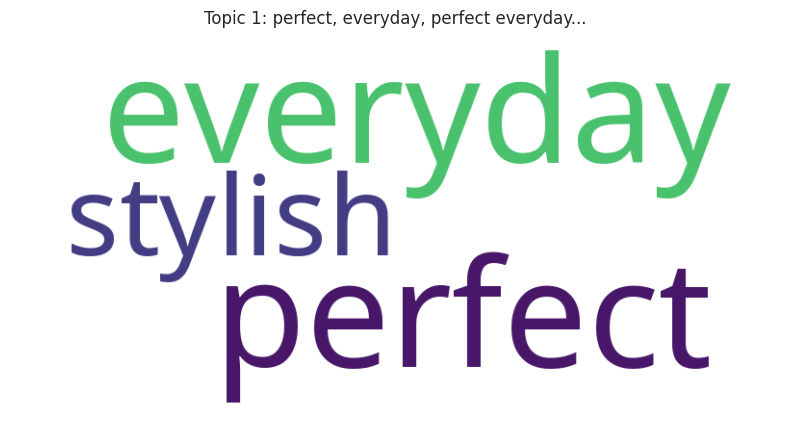

Word cloud for topic 2 saved to /mnt/c/Users/tduricic/Development/workspace/conversational-reco/results/figures/topic_wordcloud_topic_2.png


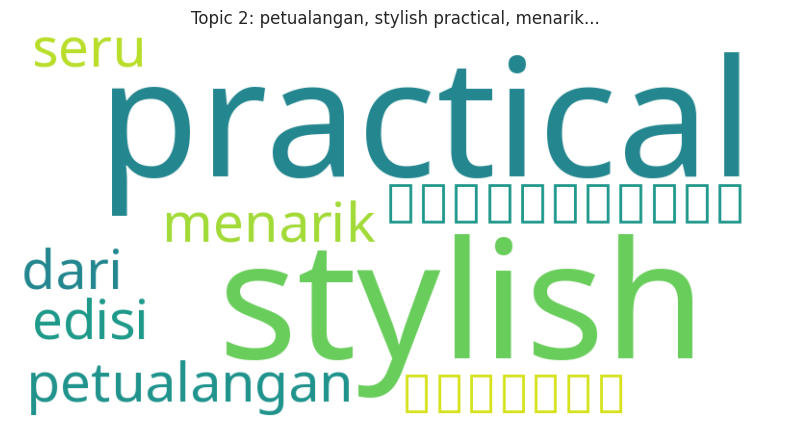

Word cloud for topic 3 saved to /mnt/c/Users/tduricic/Development/workspace/conversational-reco/results/figures/topic_wordcloud_topic_3.png


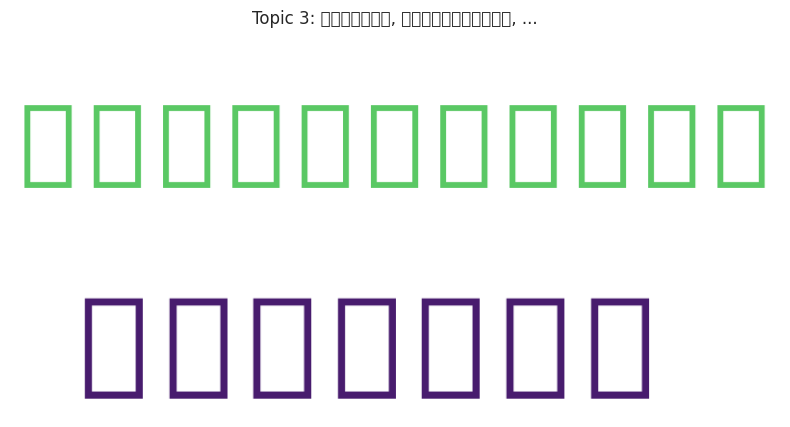

In [53]:
await full_pipeline()